In [115]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# 데이터 불러오기
df = pd.read_csv('../data_prepared/dt_2.6/ByAstar_dt_2.6_modified.csv')

df = df.dropna(subset=['combination'])

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


In [116]:

# 모델 정의
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')

# theta와 phi를 Concatenate
merged = Concatenate()([theta_input, phi_input])

# 시퀀스를 예측하기 위한 SimpleRNN 레이어
repeated_vector = RepeatVector(max_seq_length)(merged)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = SimpleRNN(64, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[theta_input, phi_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([theta_train, phi_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([theta_val, phi_val], np.expand_dims(sequence_val, -1)), epochs=10000, batch_size=128)

# 검증0
loss, accuracy = model.evaluate([theta_test, phi_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10000
87/87 [==============================] - 1s 9ms/step - loss: 1.0805 - accuracy: 0.5449 - val_loss: 0.8976 - val_accuracy: 0.5802
Epoch 2/10000
87/87 [==============================] - 1s 7ms/step - loss: 0.8785 - accuracy: 0.5844 - val_loss: 0.8757 - val_accuracy: 0.5791
Epoch 3/10000
87/87 [==============================] - 1s 7ms/step - loss: 0.8611 - accuracy: 0.5888 - val_loss: 0.8634 - val_accuracy: 0.5883
Epoch 4/10000
87/87 [==============================] - 1s 7ms/step - loss: 0.8512 - accuracy: 0.5927 - val_loss: 0.8544 - val_accuracy: 0.5900
Epoch 5/10000
87/87 [==============================] - 1s 7ms/step - loss: 0.7733 - accuracy: 0.6525 - val_loss: 0.6121 - val_accuracy: 0.7645
Epoch 6/10000
87/87 [==============================] - 1s 7ms/step - loss: 0.4865 - accuracy: 0.8197 - val_loss: 0.4317 - val_accuracy: 0.8472
Epoch 7/10000
87/87 [==============================] - 1s 7ms/step - loss: 0.4128 - accuracy: 0.8538 - val_loss: 0.4110 - val_accuracy: 0.8567

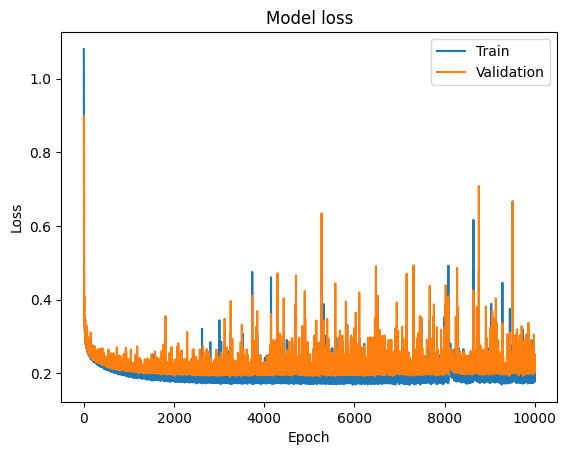

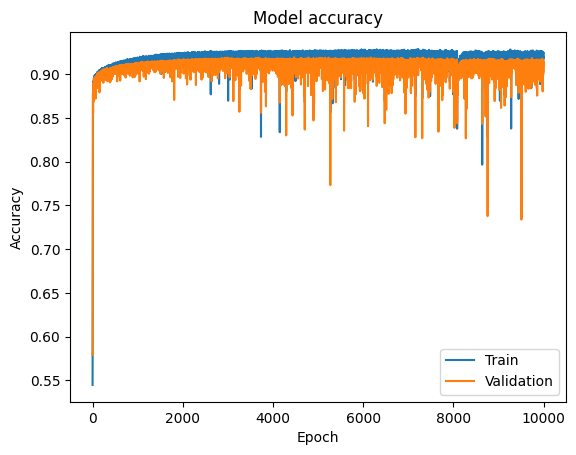

 21/108 [====>.........................] - ETA: 0s - loss: 0.2065 - accuracy: 0.9131 

/home/yeojung/.local/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['sequence_input'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


108/108 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9213
Test Accuracy: 92.13
Test Loss: 19.14


In [117]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([50, 200, 0, 1])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([50, 200, 0, 1])
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, theta_test, phi_test, sequence_test)

In [118]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_test_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "SimpleRNN_test_model.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

/home/yeojung/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [119]:
# # 가중치만 저장
# model.save_weights("model_weights.h5")

# # 구조만 저장
# model_json = model.to_json()
# with open("model_structure.json", "w") as json_file:
#     json_file.write(model_json)

# # 가중치 불러오기
# model.load_weights("model_weights.h5")

# # 구조만 불러오기
# from tensorflow.keras.models import model_from_json
# with open("model_structure.json", "r") as json_file:
#     model_json = json_file.read()
# loaded_model = model_from_json(model_json)

In [120]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'samle_test_simpleRNN'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'simpleRNN_results.csv'), index=False)

print("Results saved to simpleRNN_results.csv")


1/1 [==============================] - 0s 79ms/step
Results saved to simpleRNN_results.csv


In [1]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(theta_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([theta_samples, phi_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


NameError: name 'np' is not defined